# Task -1 Anomaly detection
## Student ID1: 345174478
## Student ID2: 326876786

#### In this assignment we will be using the Isolation Forest method to detect anomalies among the given dataset. 
#### In the following report, we have explored the data, answered the assignent questions and trained and tested our model. 

In [1]:
!pip3 install oletools

In [2]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings

In [3]:
# file path - this for linux windows you will need "//"
f_path = "/Users/rashipachino/Desktop/Ran's class/Assignment 1/conn_attack.csv"
'''
record ID - The unique identifier for each connection record.
duration_  This feature denotes the number of seconds (rounded) of the connection. For example, a connection for 0.17s or 0.3s would be indicated with a “0” in this field.
src_bytes This field represents the number of data bytes transferred from the source to the destination (i.e., the amount of out-going bytes from the host).
dst_bytes This fea
ture represents the number of data bytes transferred from the destination to the source (i.e., the amount of bytes received by the host).
'''
df = pd.read_csv(f_path,names=["record ID","duration_", "src_bytes","dst_bytes"], header=None)

# Data exploration

### Here we have explored the data in order to gain a further understanding of the features. 
##### Comments on what we learned from this are written throughout the notebook.

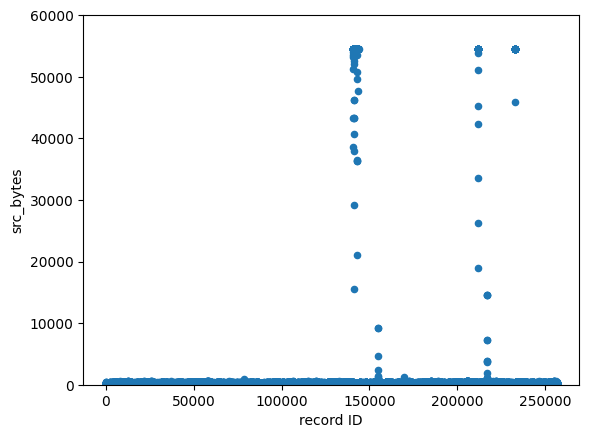

In [4]:
#Relationship with numerical variables
var = 'record ID'
data = pd.concat([df['src_bytes'], df[var]], axis=1)
data.plot.scatter(x=var, y='src_bytes', ylim=(0,60000)); 

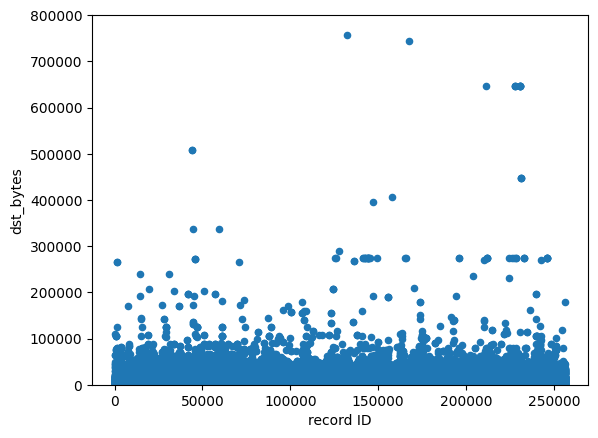

In [5]:
#Relationship with numerical variables
var = 'record ID'
data = pd.concat([df['dst_bytes'], df[var]], axis=1)
data.plot.scatter(x=var, y='dst_bytes', ylim=(0,800000)); 

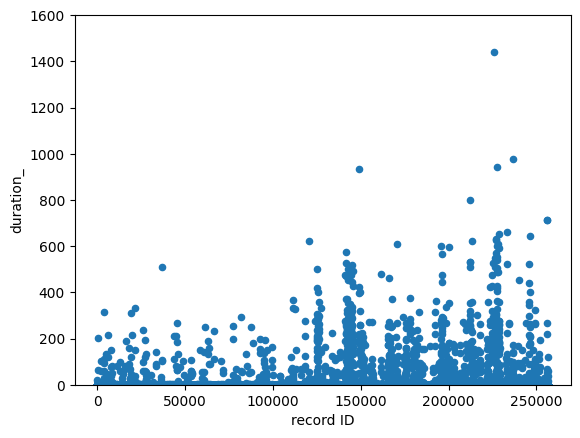

In [6]:
#Relationship with numerical variables
var = 'record ID'
data = pd.concat([df['duration_'], df[var]], axis=1)
data.plot.scatter(x=var, y='duration_', ylim=(0,1600)); 

##### By graphing the record ID against the src_bytes, dst_bytes and duration_ features, it is simplier to see which instances are anomalous. Record ID will not provide the model with any additional information about the data, and can therefore be disregarded as a feature when training the model. However, each graph produces outliers, meaning through any one feature alone (src_bytes, dst_bytes and duration_), anomalies can be detected and thus each of these features are vital for the model.  

/var/folders/cp/tgs6l5pd7yzgq5j6ww_srl1h0000gn/T/ipykernel_37706/1259533161.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['dst_bytes'])


Skewness: 207.100418
Kurtosis: 61028.785029


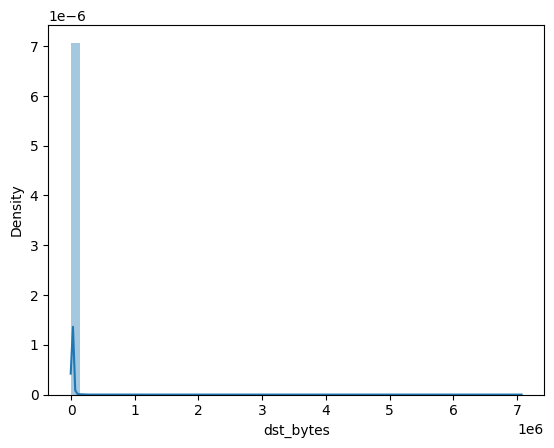

In [7]:
sns.distplot(df['dst_bytes'])
print("Skewness: %f" % df['dst_bytes'].skew())
print("Kurtosis: %f" % df['dst_bytes'].kurt())

/var/folders/cp/tgs6l5pd7yzgq5j6ww_srl1h0000gn/T/ipykernel_37706/317754786.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['duration_'])


Skewness: 74.033196
Kurtosis: 11208.320742


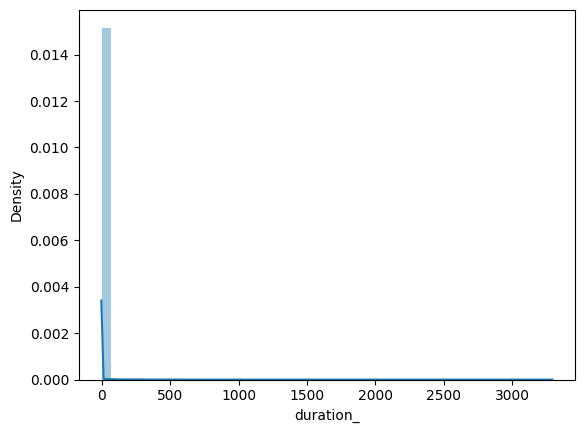

In [8]:
sns.distplot(df['duration_'])
print("Skewness: %f" % df['duration_'].skew())
print("Kurtosis: %f" % df['duration_'].kurt())

/var/folders/cp/tgs6l5pd7yzgq5j6ww_srl1h0000gn/T/ipykernel_37706/493749253.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['src_bytes'])


Skewness: 15.824471
Kurtosis: 248.739606


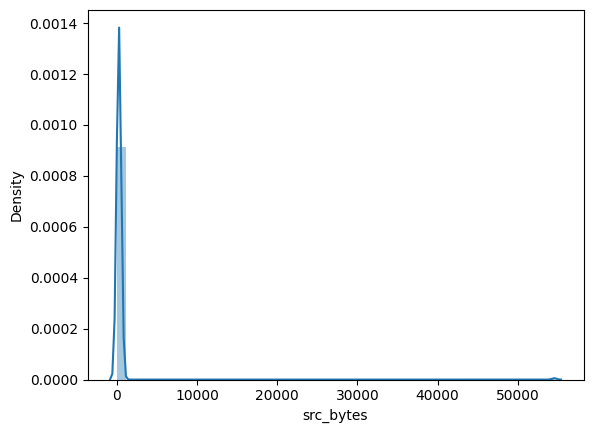

In [9]:
sns.distplot(df['src_bytes'])
print("Skewness: %f" % df['src_bytes'].skew())
print("Kurtosis: %f" % df['src_bytes'].kurt())

##### The skewness tells us that there are a higher number of datapoints having lower src_byte, dst_byte and duration_ values. So when we train our model using Isolation Forest, data points with higher values for these features will be isolated quicker. 
##### Through the skewness and kurtosis of each feature we learn the direction of the outliers. Since all three features are positively skewed, most of the outliers will be present on the right side of the distribution. It does not tell us the number of outliers, rather the direction alone. 


In [10]:
df.corr() 

,record ID,duration_,src_bytes,dst_bytes
record ID,1.000000,0.027244,0.019209,-0.002970
duration_,0.027244,1.000000,-0.001714,-0.005791
src_bytes,0.019209,-0.001714,1.000000,0.010770
dst_bytes,-0.002970,-0.005791,0.010770,1.000000


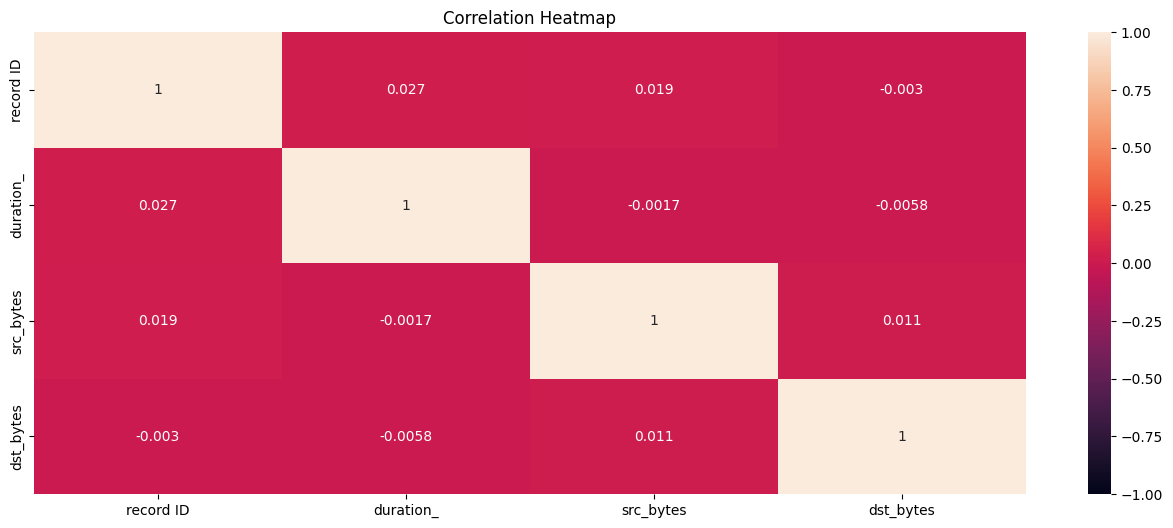

In [11]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12});

##### The correlation heatmap provides the correlation between any two features. Training a model using features that are heavily correlated is redundant. Therefore, correlation mapping is usually helpful in ridding one feature of a pair of correlated features. However, we can learn from this heatmap that our features are not highly correlated, so using all three is necessary. 

# Choosing an Unsupervised Model
##### After exploring the data, we decided on the unsupervised model Isolation Forest. Since the dataset file does not contain labels, (we we're only given labels in a seperate file to check our work) the unsupervised algorithms group is suitable for this task. 

# Why Isolation Forest?
##### Isolation forest can identify anomalous datapoints using isolation rather than modeling the normal ones. After examining the data and noticing clear outliers within the graphs, we realized that instead of constructing a profile of what's "normal", and then report anything that cannot be considered normal as anomalous, our algorithm should explicitely isolate anomalous points in the dataset. The model processes data in a tree structure based on randomly selected features. All three features add context to the model and are thus helpful when trying to isolate data points through cuts. Data points with deeper trees are less likely to be anomalies since they required more cuts to isolate them. Furthermore, data points with shorter branches indicate anomalies as it was easier for the tree to separate them from other data points. We can observe that our model is sufficient through examining the confusion matrix, precision score and recall score. 

# Training The Model
##### In this section, we train, test and validate our results with the labels file. Isoltation Forest works as an ensemble of isolation trees. We chose 100 base estimators using 205 samples each. Meaning, we trained the model on 80% of the data, and tested on the other 20%.  Comments are written throughout the code along with a confusion matrix at the bottom. 

In [12]:
plt.style.use(style='seaborn')

/var/folders/cp/tgs6l5pd7yzgq5j6ww_srl1h0000gn/T/ipykernel_37706/1064692454.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(style='seaborn')


In [13]:
DATA_PATH = "conn_attack.csv"
df = pd.read_csv(DATA_PATH, header=None, names=["record ID","duration_", "src_bytes","dst_bytes"])

In [14]:
from sklearn.ensemble import IsolationForest

data = df.drop(columns=["record ID"], axis=1).copy() # removing record ID from the feature list

In [15]:
data.values # showing that record ID was indeed dropped


array([[   0,  236, 1228],
       [   0,  239,  486],
       [   0,  234, 1364],
       ...,
       [   0,  289, 1096],
       [   0,  198, 2169],
       [   0,  212, 2288]])

In [16]:
%%time
# max features is 3 since all 3 features are useful. 
model = IsolationForest(contamination=float(0.004), n_estimators=1000, max_samples=205, max_features=3)
model.fit(data.values) 

CPU times: user 1min 2s, sys: 9.87 s, total: 1min 12s
Wall time: 1min 18s


IsolationForest(contamination=0.004, max_features=3, max_samples=205,
                n_estimators=1000)

In [17]:
# testing the model on the dataset and adding prediction as column
df["iforest"] = pd.Series(model.predict(data.values))
df["iforest"] = df["iforest"].map({1: 0, -1: 1}) # instead of 1:normal -1:anomaly, we mapped to 0:normal 1:anomaly
print(df["iforest"].value_counts())

0    255645
1      1025
Name: iforest, dtype: int64


In [18]:
# showing that the prediction column was indeed added
df

,record ID,duration_,src_bytes,dst_bytes,iforest
0,1,0,236,1228,0
1,2,0,239,486,0
2,3,0,234,1364,0
3,4,0,239,1295,0
4,5,0,181,5450,0
...,...,...,...,...,...
256665,256666,0,306,236,0
256666,256667,0,288,4017,0
256667,256668,0,289,1096,0
256668,256669,0,198,2169,0


In [19]:
df.to_csv("conn_attack_iforest_pred.csv") # output file with prediction column

In [20]:
# validating the model against the labels given
PATH_TO_LABELS = 'conn_attack_anomaly_labels.csv'
data_labels = pd.read_csv(PATH_TO_LABELS, header=None, names=["record ID","label"])

## Confusion Matrix, Accuracy and Recall

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df["iforest"], data_labels["label"], labels=[0,1])

array([[255610,     35],
       [    38,    987]])

In [22]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(data_labels["label"], df["iforest"])
print("accuracy score: {0:.3f}%".format(accuracy*100))

accuracy score: 99.972%


In [23]:
from sklearn.metrics import recall_score
recall = recall_score(data_labels["label"], df["iforest"])
print("recall score: {0:.2f}%".format(recall*100))

recall score: 96.58%


# Summary 
##### Our model has an accuracy score of 99.97% and recall score of 96.58%. The high precision score outlines the model's ability to accurately identify anomalous data. Meaning, from all the data points the model classified as anomalous, most of them were true positives. As we are dealing with anomaly detection, recall is important. Recall is the measure of predicted anomalies over the total number of anomalous data points. Emphasizing a higher recall rate means clients would prefer the false negative number to be as low as possible. This is important in anomaly detection because of the possibilty of cyber attacks that can evolve from undiagnosed anomalous data points. Therefore, we can presume that our model is satisfactory. 
### Link to Github : https://github.com/Rashipachino/Anomaly_Detection.git

In [24]:
import gradio as gr

In [25]:
def annomaly(duration_, src_bytes, dst_bytes):
    x = np.array([duration_, src_bytes, dst_bytes])
    prediction = model.predict(x.reshape(1, -1))
    return prediction

In [26]:
outputs = gr.outputs.Textbox()

app = gr.Interface(fn=annomaly, inputs=['number','number','number'], outputs=outputs,description="This is a cyber annomaly model")

/usr/local/lib/python3.10/site-packages/gradio/outputs.py:21: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


In [27]:
app.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
